# Overview full map results
Author: Jens Petit

This notebook gives a short insight into the full map obtained from around 3.5 million measurements. It is also possible to plot the raw data, however this is only possible on the server because it uses absolute paths (the data is not contained in the repo because its too large).

In [1]:
from graph_utils import pose_graph_nx as pg
from graph_utils import plotter as plt
from graph_utils import optimizer_matrix_sparse as opti
from graph_utils.db_interface import DBInterface as dbi
from graph_utils import representor
from graph_utils import sparsifier
from graph_utils import pose_graph_helper
from graph_utils import rtree
from graph_utils import merger
import networkx as nx

import matplotlib.pyplot as pyplt
import pickle
import math
import numpy as np
import pdb 
import pandas as pd
from graph_utils import pose_graph_helper as pg_help

import copy
%load_ext autoreload
%autoreload 2

In [2]:
red = (255, 0, 0, 0.6)
green = (0, 255, 0, 0.6)
blue = (0, 0, 255, 0.6)
grey = (160, 160, 160, 0.6)
violette = (255, 0, 255, 0.6)

## Loading and plotting raw data
This is only possible on the server. The plot will only show the heatmaps of a part of the map specified through location because there are too many data points.

In [3]:
full_map_raw = pickle.load( open("/home/data/graphs/pipeline/map_like/many_lines_it_2/before_window.graph", "rb"))

In [5]:
position = np.array([48.150861, 11.608640])
subgraph_raw = full_map_raw.exportSubgraphNN(lat_lon=position, k=20000)
len(subgraph_raw.nx_graph.nodes)

20000

In [9]:
plotter = plt.Plotter()
heatmap = plotter.addHeatmapLayer([subgraph_raw])
plotter.plotGmaps()

Figure(layout=FigureLayout(height='420px'))

In [4]:
len(full_map_raw.nx_graph.nodes)

3260352

In [6]:
full_map_after_window = pickle.load( open("/home/data/graphs/pipeline/map_like/many_lines_it_2/after_window.graph", "rb"))

In [7]:
len(full_map_after_window.nx_graph.nodes)

3260352

In [8]:
position = np.array([48.150861, 11.608640])
subgraph_window = full_map_after_window.exportSubgraphNN(lat_lon=position, k=20000)
len(subgraph_window.nx_graph.nodes)

20000

In [10]:
plotter = plt.Plotter()
heatmap = plotter.addHeatmapLayer([subgraph_window])
plotter.plotGmaps()

Figure(layout=FigureLayout(height='420px'))

In [12]:
heatmap.max_intensity = 100

## Loading and plotting full map
This is also locally possible as the full map is in the repo.

In [13]:
full_map = pickle.load( open("../graphs/full_map/full_map_munich.graph", "rb"))

In [14]:
position = np.array([48.150861, 11.608640])
subgraph_full = full_map.exportSubgraphNN(lat_lon=position, k=100, d_threshold=10)
print(len(subgraph_full.nx_graph.nodes))
print(len(subgraph_full.nx_graph.edges))

Not enough a nearest neighbors within threshold!
Doubling threshold...
Not enough a nearest neighbors within threshold!
Doubling threshold...
Not enough a nearest neighbors within threshold!
Doubling threshold...
Not enough a nearest neighbors within threshold!
Doubling threshold...
Not enough a nearest neighbors within threshold!
Doubling threshold...
100
99


In [15]:
print(len(full_map.nx_graph.nodes))
print(len(full_map.nx_graph.edges))

39993
40461


In [16]:
plotter = plt.Plotter()
plotter.addNodeLayer(subgraph_full, size=10)
plotter.addEdgeLayer(subgraph_full, color=(20, 20, 20, 0.8))
plotter.plotGmaps()

Figure(layout=FigureLayout(height='420px'))

Heatmap plot of the full map.

In [20]:
plotter = plt.Plotter()
plotter.addHeatmapLayer([full_map])
plotter.plotGmaps()

Figure(layout=FigureLayout(height='420px'))

### Abstract graph sample
At Hilton Munich Park

In [18]:
abstract_full = sparsifier.sparsifyPoseGraph(full_map, criteria="abstract")

Dropped 36757 edges.


In [19]:
position = np.array([ 48.151242, 11.598153 ])
subgraph = abstract_full.exportSubgraphNN(lat_lon=position, k=100, d_threshold=10000)
plotter = plt.Plotter()
plotter.addNodeLayer(subgraph)
plotter.addEdgeLayer(subgraph)
plotter.addDoorLayer(subgraph, door_hist=True)
plotter.plotGmaps()

Figure(layout=FigureLayout(height='420px'))

## Full map with edge information plot

In [21]:
position = np.array([ 48.111009, 11.540203 ])
subgraph_full = full_map.exportSubgraphNN(lat_lon=position, k=100, d_threshold=100)
print(len(subgraph_full.nx_graph.nodes))
print(len(subgraph_full.nx_graph.edges))

subgraph_sparse = sparsifier.sparsifyPoseGraph(subgraph_full, criteria='rdp', epsilon=4)
print(len(subgraph_sparse.nx_graph.nodes))
print(len(subgraph_sparse.nx_graph.edges))

Not enough a nearest neighbors within threshold!
Doubling threshold...
Not enough a nearest neighbors within threshold!
Doubling threshold...
100
100
Dropped 76 edges.
24
24


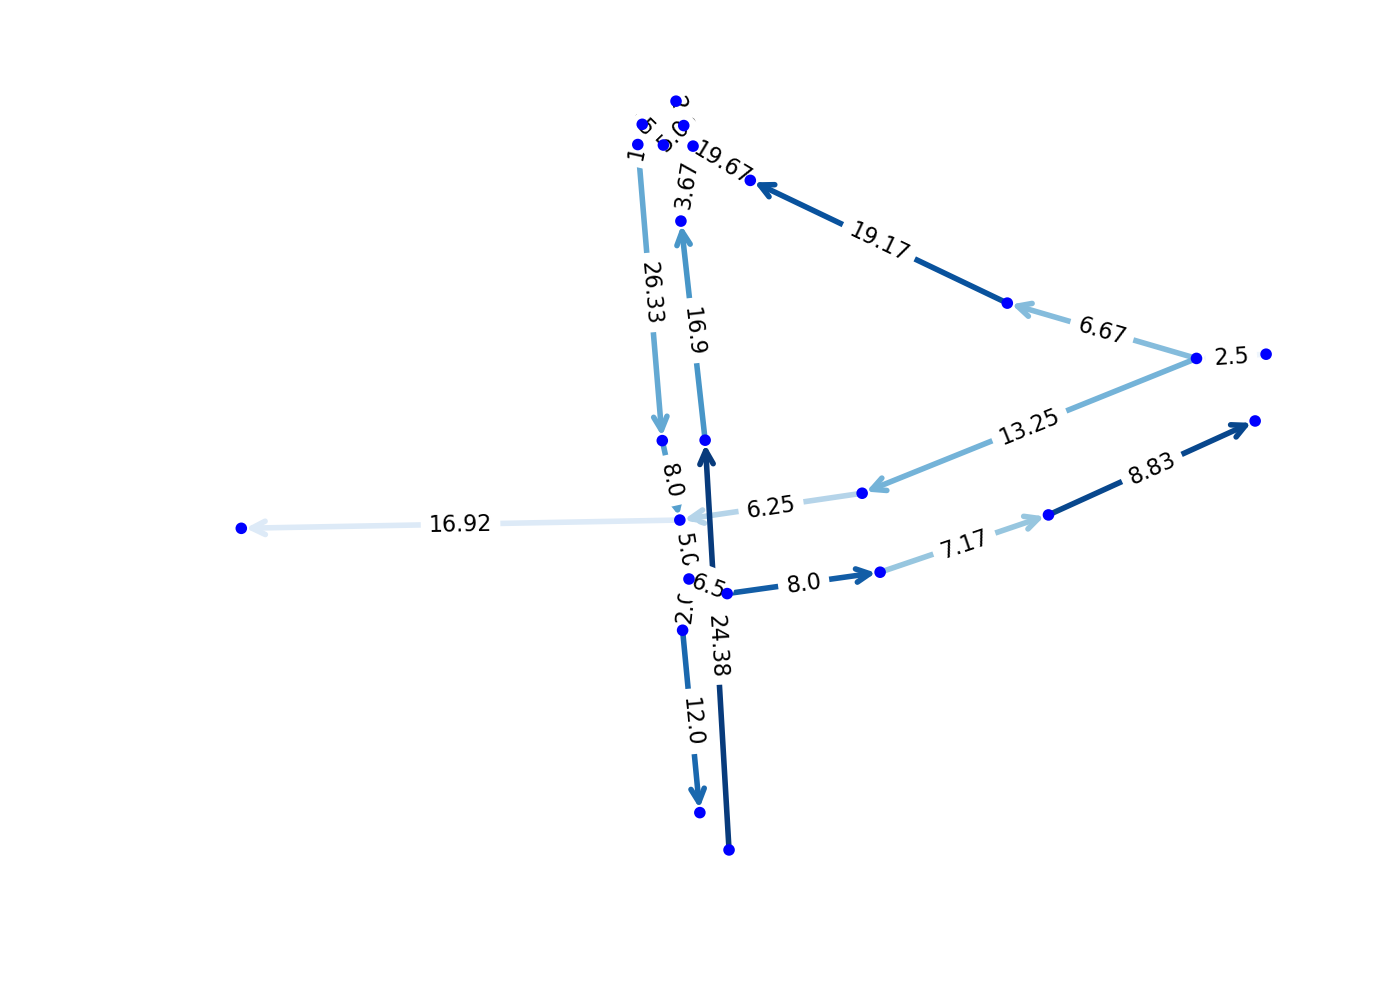

In [24]:
makePlot(subgraph_sparse)

In [23]:
def makePlot(pose_graph):
    
    nx_graph = pose_graph.nx_graph

    pyplt.figure(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')

    # Positions for all nodes
    keys, values = pose_graph.getNodeAttributeNumpy(['x','y'])
    positions = {key: values[i, :] for i, key in enumerate(keys)}
    edge_labels = nx.get_edge_attributes(nx_graph, 'travel_time')
    
    edge_labels = {key: float(("%0.2f"%a)) for key, a in edge_labels.items()}

    node_sizes = [10 for i in range(len(nx_graph))]
    M = nx_graph.number_of_edges()
    edge_colors = range(2, M + 2)

    nodes = nx.draw_networkx_nodes(nx_graph, pos=positions, node_size=node_sizes, node_color='blue')

    edges = nx.draw_networkx_edges(nx_graph, pos=positions, node_size=node_sizes, arrowstyle='->',
                                   arrowsize=12, edge_color=edge_colors,
                                   edge_cmap=pyplt.cm.Blues, width=2)

    edge_labels = nx.draw_networkx_edge_labels(nx_graph, pos=positions, 
                                               edge_labels=edge_labels,
                                               label_pos = 0.5,
                                               font_size=8)

    ax = pyplt.gca()
    ax.set_axis_off()
    pyplt.show()